# Violence Detection with MobileNetV2 with GRU

This notebook trains a MobileNetV2 model with GRU for violence detection in videos.

In [1]:
## Change the Image size from 224 to 64 due to memory constraints
## Change the Sequence length 16 to 8 due to memory constraints
## Change the Batch size from 16 to 4 due to memory constraints
## Change the MAX_VIDEOS_PER_CLASS from 1000 to 200 due to memory constraints

In [2]:
import os  # Import operating system interface module for file/directory operations
import platform  # Import module to access underlying platform's data (OS info, architecture)
from IPython.display import clear_output  # Import function to clear Jupyter notebook cell output
import numpy as np  # Import NumPy for numerical computing and array operations
import cv2  # Import OpenCV for computer vision and image processing tasks
import tensorflow as tf  # Import TensorFlow deep learning framework
from tensorflow import keras  # Import Keras high-level neural networks API from TensorFlow
from keras import layers, Model, regularizers  # Import neural network layers, Model class, and regularization functions
from keras.applications import MobileNetV2  # Import pre-trained MobileNetV2 model architecture
from keras.callbacks import (ModelCheckpoint, EarlyStopping,  # Import callback for saving model checkpoints and early stopping
                                       ReduceLROnPlateau, TensorBoard,  # Import callbacks for learning rate reduction and TensorBoard logging
                                       LearningRateScheduler, Callback)  # Import learning rate scheduler and base callback class
from sklearn.model_selection import StratifiedShuffleSplit  # Import stratified sampling for train/test splitting
from sklearn import metrics  # Import machine learning evaluation metrics
import matplotlib.pyplot as plt  # Import matplotlib for creating plots and visualizations
import seaborn as sns  # Import seaborn for statistical data visualization
from tqdm import tqdm  # Import progress bar library for loops and operations
import datetime  # Import module for working with dates and times
import subprocess  # Import module for spawning new processes and executing system commands

In [3]:
# Helper functions for directory management
def resolve_dir(Dir):  # Define function to create directory if it doesn't exist
    if not os.path.exists(Dir):  # Check if directory path does not exist
        os.makedirs(Dir)  # Create the directory (including parent directories if needed)
def reset_path(Dir):  # Define function to create/clear directory contents
    if not os.path.exists(Dir):  # Check if directory path does not exist
        os.makedirs(Dir)  # Create the directory if it doesn't exist
    else:  # If directory already exists
        # Remove files in the directory
        for filename in os.listdir(Dir):  # Iterate through all items in the directory
            file_path = os.path.join(Dir, filename)  # Create full path to each file/folder
            try:  # Attempt to delete file (with error handling)
                if os.path.isfile(file_path):  # Check if item is a file (not a subdirectory)
                    os.remove(file_path)  # Delete the file
            except Exception as e:  # Catch any errors during file deletion
                print(f"Error deleting file {file_path}: {e}")  # Print error message with file path and error details
# Create necessary directories
for dir_name in ['model', 'logs', 'images']:  # Loop through list of required directory names
    resolve_dir(dir_name)  # Create each directory if it doesn't already exist

In [4]:
# Uncomment the following line to disable GPU support
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Set environment variable to hide all GPU devices from CUDA, forcing TensorFlow to use CPU only

In [5]:
# Configure TensorFlow and GPU
tf.random.set_seed(42)  # Set random seed for TensorFlow operations to ensure reproducible results
print(platform.platform())  # Print the current operating system platform information
# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')  # Get list of all available GPU devices
if gpus:  # Check if any GPUs were found
    try:  # Attempt GPU configuration with error handling
        for gpu in gpus:  # Iterate through each available GPU
            tf.config.experimental.set_memory_growth(gpu, True)  # Enable dynamic memory allocation (prevents TensorFlow from allocating all GPU memory at once)
        print(f"{len(gpus)} GPU(s) found and configured.")  # Print number of successfully configured GPUs
    except RuntimeError as e:  # Catch runtime errors during GPU configuration
        print("Error configuring GPU memory:", e)  # Print error message if GPU configuration fails
else:  # If no GPUs are available
    print("No GPU found by TensorFlow.")  # Inform user that no GPUs were detected
# Check GPU status
system_platform = platform.system()  # Get the operating system name (Linux, Windows, Darwin/macOS)
if system_platform in ['Linux', 'Darwin', 'Windows']:  # Check if running on supported operating systems
    try:  # Attempt to run nvidia-smi command with error handling
        result = subprocess.run(["nvidia-smi"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)  # Execute nvidia-smi command to get GPU information
        if result.returncode == 0:  # Check if nvidia-smi command executed successfully
            print("nvidia-smi output:\n", result.stdout)  # Print detailed GPU information from nvidia-smi
        else:  # If nvidia-smi command failed
            print("nvidia-smi not found or no NVIDIA GPU available.")  # Inform user that nvidia-smi failed or no NVIDIA GPU exists
    except FileNotFoundError:  # Catch error when nvidia-smi command is not found
        print("nvidia-smi not found. Make sure NVIDIA drivers are installed.")  # Inform user that NVIDIA drivers may not be installed
print("TensorFlow version:", tf.__version__)  # Print the currently installed TensorFlow version
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))  # Print the total number of GPUs available to TensorFlow

Windows-10-10.0.26100-SP0
No GPU found by TensorFlow.
nvidia-smi output:
 Sat Jun  7 02:08:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.28                 Driver Version: 576.28         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              1W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                       

In [6]:
from tensorflow.python.client import device_lib  # Import TensorFlow's internal device library module for accessing device information
print(device_lib.list_local_devices())  # Print detailed information about all available devices (CPU, GPU) including device names, memory limits, and capabilities

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13419309770326603437
xla_global_id: -1
]


In [7]:
# Model hyperparameters - Improved for sequence processing
IMG_SIZE = 64  # Set image dimensions to 224x224 pixels for input to pre-trained models (standard size for ImageNet models)
SEQUENCE_LENGTH = 8  # Define number of consecutive frames to process as one sequence (for video/temporal analysis)
ColorChannels = 3  # Set number of color channels (RGB = 3 channels: Red, Green, Blue)
BATCH_SIZE = 4  # Set number of sequences to process simultaneously (small batch size due to high memory usage of sequence data)
EPOCHS = 20  # Set total number of training iterations through the entire dataset

## Dataset Configuration

In [8]:
# Base directory
PROJECT_DIR = os.path.join(os.getcwd(), 'data')  # Create path to 'data' folder in current working directory
print("Dataset path:", PROJECT_DIR)  # Print the full path to the dataset directory
if os.path.exists(PROJECT_DIR):  # Check if the data directory exists
    print("Classes:", os.listdir(PROJECT_DIR))  # List all subdirectories/files in data folder (typically class names for classification)
else:  # If data directory doesn't exist
    print("Warning: Data directory not found!")  # Print warning message that dataset is missing

Dataset path: c:\Users\USER\Documents\GitHub\CCDEPLRL_PROJECT\data
Classes: ['NonViolence', 'Violence']


In [9]:
def extract_frames_from_video(video_path, max_frames=None):  # Define function to extract frames from video file with optional frame limit
    """Extract frames from video with improved sampling"""  # Function docstring describing its purpose
    frames = []  # Initialize empty list to store extracted frames
    vidcap = cv2.VideoCapture(video_path)  # Create OpenCV VideoCapture object to read video file
   
    # Get video properties
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total number of frames in the video
    fps = vidcap.get(cv2.CAP_PROP_FPS)  # Get frames per second (frame rate) of the video
   
    if max_frames and total_frames > max_frames:  # Check if frame limit is specified and video exceeds that limit
        # Sample frames evenly across the video
        frame_indices = np.linspace(0, total_frames - 1, max_frames, dtype=int)  # Create evenly spaced frame indices across video duration
    else:  # If no frame limit or video is short enough
        # Take every 3rd frame to reduce redundancy while maintaining temporal info
        frame_indices = range(0, total_frames, 3)  # Create range of every 3rd frame index to reduce data while preserving temporal information
   
    success = True  # Initialize flag to track if frame reading is successful
    frame_count = 0  # Initialize counter for current frame position
   
    while success and frame_count < total_frames:  # Loop through video frames until end or failure
        success, image = vidcap.read()  # Read next frame from video (returns success flag and frame data)
        if success and frame_count in frame_indices:  # Check if frame was read successfully and is one of the selected frames
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR (OpenCV default) to RGB color format
            image_resized = cv2.resize(image_rgb, (IMG_SIZE, IMG_SIZE))  # Resize frame to specified dimensions (224x224)
            frames.append(image_resized)  # Add processed frame to the frames list
        frame_count += 1  # Increment frame counter
   
    vidcap.release()  # Release video capture object to free memory
    return np.array(frames)  # Convert frames list to NumPy array and return

In [10]:
def create_sequences(frames, sequence_length=SEQUENCE_LENGTH):  # Define function to create frame sequences with default length from global variable
    """Create sequences of frames for temporal analysis"""  # Function docstring describing its purpose
    sequences = []  # Initialize empty list to store frame sequences
   
    if len(frames) < sequence_length:  # Check if available frames are fewer than required sequence length
        # If not enough frames, pad with last frame
        padding_needed = sequence_length - len(frames)  # Calculate how many additional frames are needed
        if len(frames) > 0:  # Check if there are any frames available
            padded_frames = np.concatenate([frames,  # Combine original frames with padding
                                          np.repeat(frames[-1:], padding_needed, axis=0)])  # Repeat the last frame to fill missing positions
        else:  # If no frames are available at all
            # If no frames at all, create black frames
            padded_frames = np.zeros((sequence_length, IMG_SIZE, IMG_SIZE, ColorChannels))  # Create sequence of black/zero frames with correct dimensions
        sequences.append(padded_frames)  # Add the padded sequence to sequences list
    else:  # If there are enough frames for at least one complete sequence
        # Create overlapping sequences
        for i in range(0, len(frames) - sequence_length + 1, sequence_length // 2):  # Loop with step size of half sequence length for overlap
            sequence = frames[i:i + sequence_length]  # Extract consecutive frames for one sequence
            sequences.append(sequence)  # Add the sequence to sequences list
   
    return np.array(sequences)  # Convert sequences list to NumPy array and return

## Load and Prepare Dataset

In [11]:
# Load and process data with sequence creation
print("Loading and processing video data...")  # Print status message for data loading process
VideoDataDir = PROJECT_DIR  # Set video data directory to the project directory path
CLASSES = ["NonViolence", "Violence"]  # Define class labels for binary classification (non-violent vs violent videos)
MAX_VIDEOS_PER_CLASS = 200  # Set maximum number of videos to process per class to manage memory usage
X_sequences = []  # Initialize list to store input sequences (features)
y_sequences = []  # Initialize list to store corresponding labels (targets)
for category in CLASSES:  # Loop through each class category
    path = os.path.join(VideoDataDir, category)  # Create path to current category's directory
    if not os.path.exists(path):  # Check if category directory exists
        print(f"Warning: Directory {path} does not exist!")  # Print warning if directory is missing
        continue  # Skip to next category
       
    print(f"Processing {category} data...")  # Print current category being processed
    class_num = CLASSES.index(category)  # Get numeric index for current class (0 for NonViolence, 1 for Violence)
   
    # Get list of image files (assuming frames are already extracted)
    image_files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.png', '.jpeg'))]  # Filter files to only include image formats
   
    if not image_files:  # Check if any image files were found
        print(f"No image files found in {path}")  # Print message if no images found
        continue  # Skip to next category
   
    # Group images by video (assuming format: videoname-framenum.jpg)
    video_groups = {}  # Initialize dictionary to group frames by video name
    for img_file in image_files:  # Loop through each image file
        video_name = img_file.split('-')[0]  # Extract video name (part before first dash)
        if video_name not in video_groups:  # Check if video group doesn't exist yet
            video_groups[video_name] = []  # Create new list for this video
        video_groups[video_name].append(img_file)  # Add image file to corresponding video group
   
    # Process each video group
    processed_videos = 0  # Initialize counter for processed videos
    for video_name, img_files in tqdm(video_groups.items(),  # Loop through video groups with progress bar
                                     desc=f"Processing {category} videos"):  # Set progress bar description
        if processed_videos >= MAX_VIDEOS_PER_CLASS:  # Check if maximum videos per class reached
            break  # Stop processing more videos
           
        # Sort files by frame number
        img_files.sort(key=lambda x: int(x.split('-')[1].split('.')[0]))  # Sort images by frame number (extracted from filename)
       
        # Load frames
        frames = []  # Initialize list to store frames for current video
        for img_file in img_files:  # Loop through each image file in current video
            img_path = os.path.join(path, img_file)  # Create full path to image file
            try:  # Attempt to load image with error handling
                img = cv2.imread(img_path)  # Load image using OpenCV
                if img is not None:  # Check if image loaded successfully
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB color space
                    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))  # Resize image to model input size
                    frames.append(img_resized)  # Add processed frame to frames list
            except Exception as e:  # Catch any errors during image processing
                print(f"Error processing {img_path}: {e}")  # Print error message with file path and error details
       
        if len(frames) > 0:  # Check if any frames were successfully loaded
            # Create sequences from frames
            sequences = create_sequences(np.array(frames))  # Convert frames to sequences using helper function
           
            # Add sequences to dataset
            for sequence in sequences:  # Loop through each created sequence
                X_sequences.append(sequence)  # Add sequence to input data
                y_sequences.append(class_num)  # Add corresponding class label
           
            processed_videos += 1  # Increment processed videos counter
# Convert to numpy arrays
X_sequences = np.array(X_sequences, dtype=np.float32) / 255.0  # Convert to NumPy array, set float32 type, and normalize pixel values to 0-1 range
y_sequences = np.array(y_sequences)  # Convert labels to NumPy array
print(f"Total sequences: {len(X_sequences)}")  # Print total number of sequences created
print(f"Sequence shape: {X_sequences.shape}")  # Print shape of input sequences array
print(f"Labels shape: {y_sequences.shape}")  # Print shape of labels array

Loading and processing video data...
Processing NonViolence data...


Processing NonViolence videos:  20%|██        | 200/1000 [01:49<07:18,  1.82it/s]


Processing Violence data...


Processing Violence videos:  20%|██        | 200/1000 [02:13<08:55,  1.49it/s]


Total sequences: 4015
Sequence shape: (4015, 8, 64, 64, 3)
Labels shape: (4015,)


## Split Data into Training and Testing Sets

In [12]:
# Split data with stratification
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # Create stratified splitter with 80/20 train/test split, maintaining class distribution
for train_idx, test_idx in stratified_split.split(X_sequences, y_sequences):  # Loop through split indices (only one iteration since n_splits=1)
    X_train = X_sequences[train_idx]  # Extract training sequences using train indices
    X_test = X_sequences[test_idx]  # Extract testing sequences using test indices
    y_train = y_sequences[train_idx]  # Extract training labels using train indices
    y_test = y_sequences[test_idx]  # Extract testing labels using test indices
print(f"Training sequences: {X_train.shape}")  # Print shape of training data
print(f"Testing sequences: {X_test.shape}")  # Print shape of testing data

Training sequences: (3212, 8, 64, 64, 3)
Testing sequences: (803, 8, 64, 64, 3)


## Define and Build the MobileNetV2 Model

In [13]:
# Build MobileNetV2 + GRU model
def build_mobilenetv2_gru_model():  # Define function to build hybrid CNN-RNN model
    """Build a model combining MobileNetV2 feature extraction with GRU temporal modeling"""  # Function docstring
   
    # Input for sequences
    sequence_input = layers.Input(shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, ColorChannels))  # Define input layer for video sequences with shape (frames, height, width, channels)
   
    # Create MobileNetV2 base model (without top layers)
    mobilenet_base = MobileNetV2(  # Create MobileNetV2 pre-trained model
        input_shape=(IMG_SIZE, IMG_SIZE, ColorChannels),  # Set input shape for individual frames
        include_top=False,  # Exclude final classification layers to use as feature extractor
        weights='imagenet',  # Load pre-trained ImageNet weights
        pooling='avg',  # Use global average pooling instead of flattening
        alpha=1.0  # Use full model width (no compression) for better feature extraction
    )
   
    # Freeze MobileNetV2 layers initially
    mobilenet_base.trainable = False  # Freeze pre-trained weights to prevent updating during initial training
   
    # Apply MobileNetV2 to each frame in the sequence
    encoded_frames = layers.TimeDistributed(mobilenet_base)(sequence_input)  # Apply CNN to each frame independently using TimeDistributed wrapper
   
    # Add additional dense layer for feature refinement
    encoded_frames = layers.TimeDistributed(  # Apply dense layer to each frame's features
        layers.Dense(512, activation='relu')  # Add fully connected layer with 512 neurons and ReLU activation
    )(encoded_frames)
   
    # Add dropout for regularization
    encoded_frames = layers.TimeDistributed(  # Apply dropout to each frame's features
        layers.Dropout(0.3)  # Set dropout rate to 30% to prevent overfitting
    )(encoded_frames)
   
    # GRU layers for temporal modeling
    gru1 = layers.GRU(  # First GRU layer for temporal sequence modeling
        256,  # Set 256 hidden units
        return_sequences=True,  # Return full sequence (not just last output) for next GRU layer
        dropout=0.3,  # Apply 30% dropout to inputs
        recurrent_dropout=0.2,  # Apply 20% dropout to recurrent connections
        kernel_regularizer=regularizers.l2(0.001)  # Apply L2 regularization with weight 0.001
    )(encoded_frames)
   
    gru2 = layers.GRU(  # Second GRU layer for deeper temporal modeling
        128,  # Set 128 hidden units (smaller than first layer)
        return_sequences=False,  # Return only last output (sequence-to-one)
        dropout=0.3,  # Apply 30% dropout to inputs
        recurrent_dropout=0.2,  # Apply 20% dropout to recurrent connections
        kernel_regularizer=regularizers.l2(0.001)  # Apply L2 regularization with weight 0.001
    )(gru1)
   
    # Final classification layers
    dense1 = layers.Dense(  # First dense layer for classification
        64,  # Set 64 neurons
        activation='relu',  # Use ReLU activation function
        kernel_regularizer=regularizers.l2(0.001)  # Apply L2 regularization with weight 0.001
    )(gru2)
   
    dropout_final = layers.Dropout(0.5)(dense1)  # Apply 50% dropout before final output layer
   
    # Output layer
    output = layers.Dense(1, activation='sigmoid')(dropout_final)  # Single neuron with sigmoid activation for binary classification (0-1 probability)
   
    # Create model
    model = Model(inputs=sequence_input, outputs=output)  # Create Keras model with defined input and output layers
   
    return model, mobilenet_base  # Return both the complete model and the MobileNet base for potential fine-tuning

In [14]:
# Build the model
print("Building MobileNetV2 + GRU model...")  # Print status message for model building
model, mobilenet_base = build_mobilenetv2_gru_model()  # Call function to create model and get both complete model and MobileNet base
# Compile model with improved optimizer settings
model.compile(  # Configure model for training
    optimizer=keras.optimizers.Adam(  # Use Adam optimizer with custom parameters
        learning_rate=0.0001,  # Set learning rate to 0.0001 (conservative for fine-tuning)
        beta_1=0.9,  # Set first moment decay rate (default value for momentum)
        beta_2=0.999,  # Set second moment decay rate (default value for RMSprop-like behavior)
        epsilon=1e-7  # Set small constant to prevent division by zero in optimizer
    ),
    loss='binary_crossentropy',  # Use binary cross-entropy loss for binary classification
    metrics=['accuracy', 'precision', 'recall']  # Track accuracy, precision, and recall during training
)
print("Model compiled successfully!")  # Print confirmation message
model.summary()  # Display detailed model architecture summary with layer information and parameter counts

Building MobileNetV2 + GRU model...
Model compiled successfully!
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 64, 64, 3)]    0         
                                                                 
 time_distributed (TimeDistr  (None, 8, 1280)          2257984   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 8, 512)           655872    
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 8, 512)           0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 8, 256)            591360 

In [15]:
# Advanced learning rate scheduling
def cosine_annealing_with_warmup(epoch, warmup_epochs=5, total_epochs=EPOCHS,  # Define function with epoch number and training parameters
                                min_lr=1e-6, max_lr=1e-3):  # Set minimum and maximum learning rates
    """Cosine annealing with warmup"""  # Function docstring describing the learning rate strategy
    if epoch < warmup_epochs:  # Check if current epoch is in warmup phase
        return min_lr + (max_lr - min_lr) * epoch / warmup_epochs  # Linear increase from min_lr to max_lr during warmup
    else:  # If past warmup phase, enter cosine annealing phase
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)  # Calculate progress through annealing phase (0 to 1)
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * progress))  # Apply cosine decay from max_lr to min_lr

In [16]:
class GradualUnfreezing(Callback):  # Define custom callback class for progressive layer unfreezing
    """Gradually unfreeze MobileNetV2 layers during training"""  # Class docstring
    def __init__(self, mobilenet_base, unfreeze_epoch=15):  # Initialize callback with MobileNet model and unfreezing epoch
        super().__init__()  # Call parent class constructor
        self.mobilenet_base = mobilenet_base  # Store reference to MobileNet base model
        self.unfreeze_epoch = unfreeze_epoch  # Set epoch number when to unfreeze layers
        self.unfrozen = False  # Initialize flag to track if unfreezing has occurred
   
    def on_epoch_begin(self, epoch, logs=None):  # Define method called at beginning of each epoch
        if epoch == self.unfreeze_epoch and not self.unfrozen:  # Check if target epoch reached and not already unfrozen
            print(f"\nUnfreezing MobileNetV2 layers at epoch {epoch}")  # Print unfreezing notification
            self.mobilenet_base.trainable = True  # Enable training for all MobileNet layers
           
            # Use lower learning rate for fine-tuning
            self.model.optimizer.learning_rate = 1e-5  # Reduce learning rate for fine-tuning pre-trained layers
            self.unfrozen = True  # Set flag to prevent multiple unfreezing

## Set Up Callbacks and Training Parameters

In [17]:
# Enhanced early stopping callback
class EnhancedEarlyStopping(Callback):  # Define custom callback class inheriting from Keras Callback
    """Enhanced early stopping with accuracy threshold"""  # Class docstring
    def __init__(self, patience=10, min_delta=0.001, accuracy_threshold=0.98):  # Initialize callback with parameters
        super().__init__()  # Call parent class constructor
        self.patience = patience  # Set number of epochs to wait before stopping
        self.min_delta = min_delta  # Set minimum improvement threshold for validation loss
        self.accuracy_threshold = accuracy_threshold  # Set target accuracy to trigger early stopping
        self.best_loss = np.inf  # Initialize best validation loss to infinity
        self.wait = 0  # Initialize counter for epochs without improvement
        self.best_weights = None  # Initialize storage for best model weights
   
    def on_epoch_end(self, epoch, logs=None):  # Define method called at end of each epoch
        current_loss = logs.get('val_loss')  # Get current validation loss from training logs
        current_accuracy = logs.get('val_accuracy')  # Get current validation accuracy from training logs
       
        # Stop if accuracy threshold is reached
        if current_accuracy and current_accuracy >= self.accuracy_threshold:  # Check if accuracy threshold is met
            print(f"\nAccuracy threshold {self.accuracy_threshold} reached! Stopping training.")  # Print success message
            self.model.stop_training = True  # Signal Keras to stop training
            return  # Exit method early
       
        # Regular early stopping logic
        if current_loss < self.best_loss - self.min_delta:  # Check if validation loss improved significantly
            self.best_loss = current_loss  # Update best loss record
            self.wait = 0  # Reset patience counter
            self.best_weights = self.model.get_weights()  # Save current weights as best
        else:  # If no significant improvement
            self.wait += 1  # Increment patience counter
            if self.wait >= self.patience:  # Check if patience limit reached
                print(f"\nEarly stopping at epoch {epoch + 1}")  # Print early stopping message
                if self.best_weights is not None:  # Check if best weights were saved
                    self.model.set_weights(self.best_weights)  # Restore best weights to model
                self.model.stop_training = True  # Signal Keras to stop training

In [18]:
# Setup callbacks
log_dir = f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"  # Create timestamped directory path for TensorBoard logs
checkpoint_path = 'model/best_mobilenetv2_gru_weights.h5'  # Set file path for saving best model weights
model_save_path = 'model/mobilenetv2_gru_model.h5'  # Set file path for saving complete model
callbacks = [  # Initialize list of training callbacks
    # Learning rate scheduling
    LearningRateScheduler(cosine_annealing_with_warmup, verbose=1),  # Apply custom learning rate schedule with progress output
   
    # Model checkpointing
    ModelCheckpoint(  # Save best model weights during training
        filepath=checkpoint_path,  # Set file path for saving weights
        monitor='val_loss',  # Monitor validation loss to determine best model
        save_best_only=True,  # Only save when validation loss improves
        save_weights_only=True,  # Save only weights (not full model architecture)
        mode='min',  # Save when monitored metric decreases
        verbose=1  # Print message when saving
    ),
   
    # Enhanced early stopping
    EnhancedEarlyStopping(patience=15, min_delta=0.001, accuracy_threshold=0.95),  # Use custom early stopping with 15 epoch patience and 95% accuracy threshold
   
    # Reduce learning rate on plateau
    ReduceLROnPlateau(  # Reduce learning rate when validation loss plateaus
        monitor='val_loss',  # Monitor validation loss for plateau detection
        factor=0.5,  # Multiply learning rate by 0.5 when plateau detected
        patience=5,  # Wait 5 epochs before reducing learning rate
        min_lr=1e-7,  # Set minimum learning rate limit
        verbose=1  # Print message when reducing learning rate
    ),
   
    # TensorBoard logging
    TensorBoard(  # Enable TensorBoard visualization and logging
        log_dir=log_dir,  # Set directory for TensorBoard logs
        histogram_freq=1,  # Log weight histograms every epoch
        write_graph=True,  # Save model graph structure
        write_images=True  # Save sample images to TensorBoard
    ),
   
    # Gradual unfreezing
    GradualUnfreezing(mobilenet_base, unfreeze_epoch=20)  # Gradually unfreeze MobileNet layers starting at epoch 20
]

## Train the Model

In [19]:
from keras.metrics import Precision, Recall

# Define your metrics properly
metrics = [
    'accuracy',
    Precision(name='precision'),  # Properly initialized precision metric
    Recall(name='recall')        # Properly initialized recall metric
]

# Recompile the model with correct metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    ),
    loss='binary_crossentropy',
    metrics=metrics
)

# Train the model

# Print a message indicating the start of training
print("Starting training...")

# Print the number of training and validation sequences
print(f"Training with {len(X_train)} sequences, validating with {len(X_test)} sequences")

# Train the model using the training data (X_train, y_train) and validate on test data (X_test, y_test)
history = model.fit(
    X_train, y_train,                # Training data (features and labels)
    epochs=EPOCHS,                   # Number of training iterations
    batch_size=BATCH_SIZE,           # Number of samples per gradient update
    validation_data=(X_test, y_test),# Data to evaluate model performance after each epoch
    callbacks=callbacks,             # Optional callbacks (e.g., checkpointing, early stopping)
    verbose=1                        # Show progress bar and metrics per epoch
)

# Load the best model weights (e.g., from a checkpoint saved during training)
print("Loading best weights...")
model.load_weights(checkpoint_path)   # Restores the best-performing weights

# Save the entire trained model (architecture + weights + optimizer state) to a file
model.save(model_save_path)          
print(f"Model saved to {model_save_path}")  # Confirms where the model was saved

# Convert the Keras model to TensorFlow Lite format (for deployment on mobile/edge devices)
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # Initialize the converter

# Enable these options to handle unsupported ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops fallback
]
converter._experimental_lower_tensor_list_ops = False  # Disable tensor list lowering
tflite_model = converter.convert()   # Perform the conversion

# Save the resulting TFLite model to a binary file
with open('model/violence_model.tflite', 'wb') as f:  # Open file in write-binary mode
    f.write(tflite_model)            # Write the TFLite model bytes to the file

Starting training...
Training with 3212 sequences, validating with 803 sequences

Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/20
803/803 [==============================] - ETA: 0s - loss: 1.6927 - accuracy: 0.5635 - precision: 0.5910 - recall: 0.6324
Epoch 1: val_loss improved from inf to 1.64760, saving model to model\best_mobilenetv2_gru_weights.h5
803/803 [==============================] - 126s 148ms/step - loss: 1.6927 - accuracy: 0.5635 - precision: 0.5910 - recall: 0.6324 - val_loss: 1.6476 - val_accuracy: 0.6824 - val_precision: 0.6673 - val_recall: 0.8253 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.0009938503377876118.
Epoch 2/20
803/803 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.9309 - precision: 0.9318 - recall: 0.9414
Epoch 2: val_loss improved from 1.64760 to 0.39157, saving model to model\best_mobilenetv2_gru_weights.h5

Accuracy threshold 0.95 reached! Stopping training.
803/803 [=====

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpoiqjtexx\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpoiqjtexx\assets


## Evaluate the Model

In [20]:
# Evaluation and visualization functions
def plot_training_history(history, save_dir='images'):
    """Plot training history with enhanced visualization"""
    # Create a 2x2 grid of subplots with a larger figure size (15x12 inches)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # --- Loss Plot (Top-left subplot) ---
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)  # Plot training loss
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)  # Plot validation loss
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')  # Set subplot title
    axes[0, 0].set_xlabel('Epoch')  # Label x-axis
    axes[0, 0].set_ylabel('Loss')  # Label y-axis
    axes[0, 0].legend()  # Show legend
    axes[0, 0].grid(True, alpha=0.3)  # Add semi-transparent grid
    
    # --- Accuracy Plot (Top-right subplot) ---
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)  # Plot training accuracy
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)  # Plot validation accuracy
    axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')  # Set subplot title
    axes[0, 1].set_xlabel('Epoch')  # Label x-axis
    axes[0, 1].set_ylabel('Accuracy')  # Label y-axis
    axes[0, 1].legend()  # Show legend
    axes[0, 1].grid(True, alpha=0.3)  # Add semi-transparent grid
    
    # --- Precision Plot (Bottom-left subplot, conditional) ---
    if 'precision' in history.history:  # Check if precision was logged during training
        axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)  # Plot training precision
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)  # Plot validation precision
        axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')  # Set subplot title
        axes[1, 0].set_xlabel('Epoch')  # Label x-axis
        axes[1, 0].set_ylabel('Precision')  # Label y-axis
        axes[1, 0].legend()  # Show legend
        axes[1, 0].grid(True, alpha=0.3)  # Add semi-transparent grid
    
    # --- Recall Plot (Bottom-right subplot, conditional) ---
    if 'recall' in history.history:  # Check if recall was logged during training
        axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)  # Plot training recall
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)  # Plot validation recall
        axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')  # Set subplot title
        axes[1, 1].set_xlabel('Epoch')  # Label x-axis
        axes[1, 1].set_ylabel('Recall')  # Label y-axis
        axes[1, 1].legend()  # Show legend
        axes[1, 1].grid(True, alpha=0.3)  # Add semi-transparent grid
    
    plt.tight_layout()  # Adjust spacing between subplots to prevent overlap
    plt.savefig(os.path.join(save_dir, 'training_history.png'), dpi=300, bbox_inches='tight')  # Save figure as high-res PNG
    plt.show()  # Display the figure

## Generate Detailed Metrics

Evaluating model...
26/26 [==============================] - 12s 472ms/step - loss: 0.3916 - accuracy: 0.9776 - precision: 0.9860 - recall: 0.9724

Test Results:
Loss: 0.3916
Accuracy: 0.9776
Precision: 0.9860
Recall: 0.9724
F1 Score: 0.9792
Generating predictions...
201/201 [==============================] - 22s 101ms/step


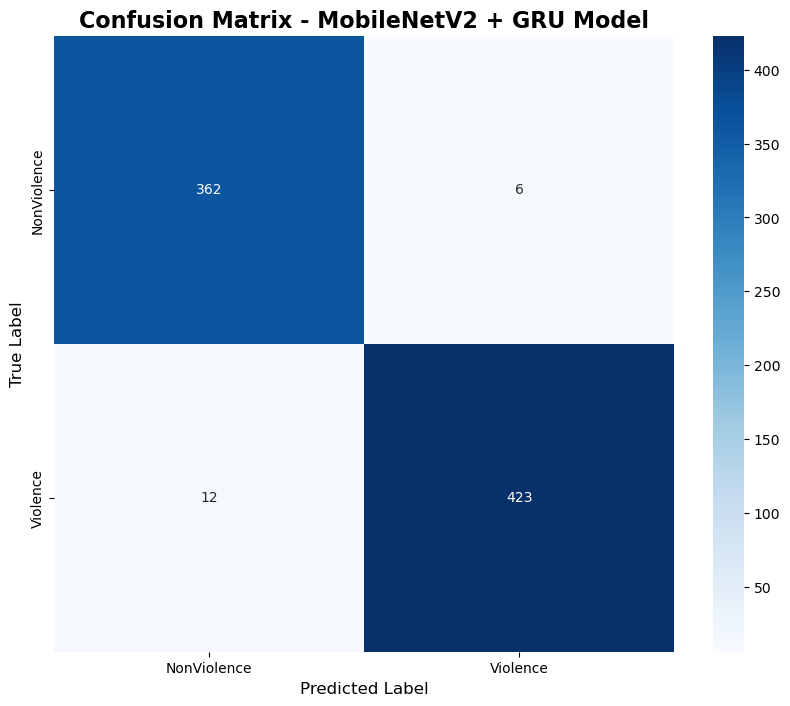


Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.97      0.98      0.98       368
    Violence       0.99      0.97      0.98       435

    accuracy                           0.98       803
   macro avg       0.98      0.98      0.98       803
weighted avg       0.98      0.98      0.98       803



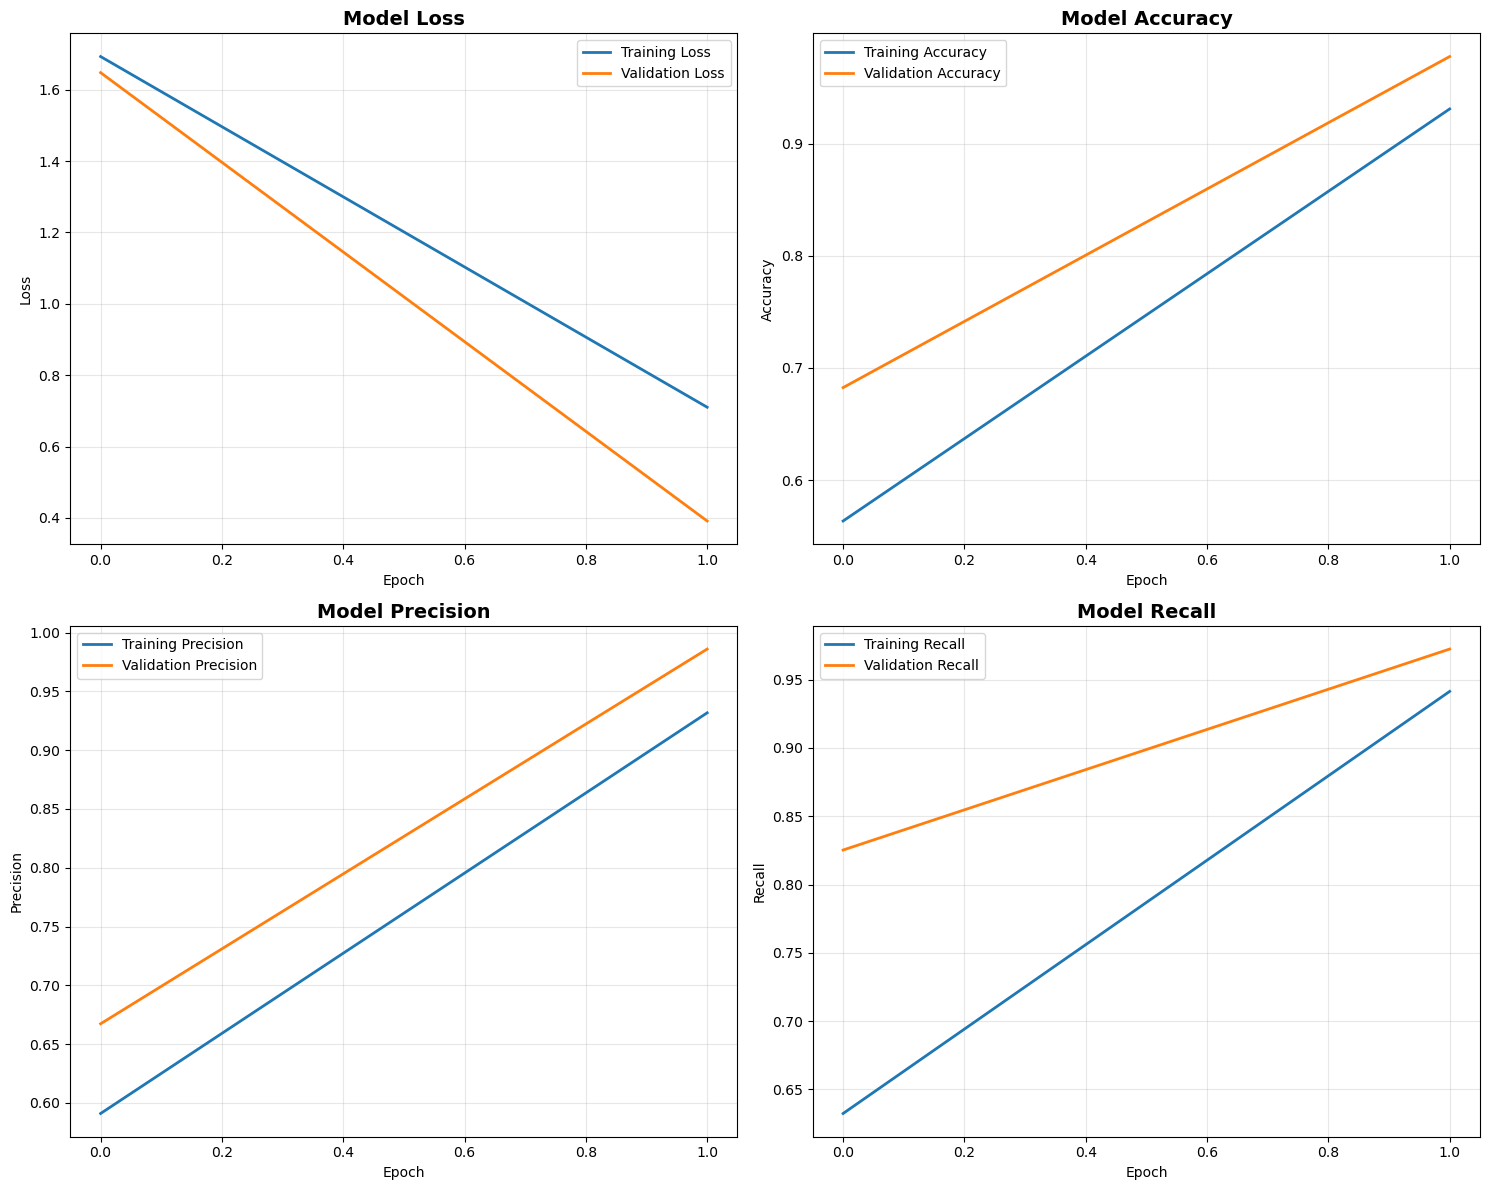

In [21]:
from sklearn import metrics

# Model evaluation

# Print message indicating evaluation is starting
print("Evaluating model...")

# Evaluate model on test data and get metrics
# Returns: loss, accuracy, precision, recall (order depends on model compilation)
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=1)

# Print formatted test results with 4 decimal places
print(f"\nTest Results:")
print(f"Loss: {test_loss:.4f}")          # Model's total loss
print(f"Accuracy: {test_accuracy:.4f}")  # Overall correctness
print(f"Precision: {test_precision:.4f}")  # True positives / (True positives + False positives)
print(f"Recall: {test_recall:.4f}")      # True positives / (True positives + False negatives)

# Calculate F1 Score (harmonic mean of precision and recall)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"F1 Score: {f1_score:.4f}")  # Balanced metric for imbalanced datasets

# Generate predictions for confusion matrix and classification report
print("Generating predictions...")
y_pred_prob = model.predict(X_test, batch_size=BATCH_SIZE)  # Get raw probabilities
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert to binary predictions (threshold=0.5)

# Create and visualize confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)  # Compute confusion matrix
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(
    cm, 
    annot=True,              # Show numbers in cells
    fmt='d',                 # Integer formatting
    cmap='Blues',            # Color scheme
    xticklabels=['NonViolence', 'Violence'],  # X-axis labels
    yticklabels=['NonViolence', 'Violence']   # Y-axis labels
)
plt.title('Confusion Matrix - MobileNetV2 + GRU Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.savefig('images/confusion_matrix_gru.png', dpi=300, bbox_inches='tight')  # Save high-quality image
plt.show()  # Display plot

# Print detailed classification report
print("\nClassification Report:")
print(metrics.classification_report(
    y_test, 
    y_pred, 
    target_names=['NonViolence', 'Violence']  # Custom class labels
))

# Plot training history (loss, accuracy, etc. over epochs)
plot_training_history(history)  # Calls previously defined visualization function

## Test Prediction on a Sample Video

In [22]:
# Test model loading functionality to verify the saved model can be properly loaded

# Print message indicating model loading test is starting
print("\nTesting model loading...")

# Attempt to load the saved model with error handling
try:
    # Load the complete model (architecture + weights + optimizer state) from saved path
    loaded_model = keras.models.load_model(model_save_path)
    print("Model loaded successfully!")  # Success confirmation
    
    # Perform a quick test prediction if test data exists
    if len(X_test) > 0:  # Check if test data is available
        # Take the first sample from test set (shape preserving with [:1])
        test_sample = X_test[:1]
        
        # Get model prediction (returns probability for binary classification)
        prediction = loaded_model.predict(test_sample)[0][0]  # Extract scalar probability
        actual = y_test[0]  # Get corresponding true label
        
        # Print prediction results with formatting
        print(f"Test prediction: {prediction:.4f} (threshold: 0.5)")  # Raw probability
        # Convert probability to class prediction using 0.5 threshold
        print(f"Predicted class: {'Violence' if prediction > 0.5 else 'NonViolence'}")
        # Show actual class (assuming 1=Violence, 0=NonViolence)
        print(f"Actual class: {'Violence' if actual == 1 else 'NonViolence'}")

# Handle potential loading errors gracefully
except Exception as e:  # Catch any exception during loading/prediction
    print(f"Error loading model: {e}")  # Print error message for debugging


Testing model loading...
Model loaded successfully!
1/1 [==============================] - 2s 2s/step
Test prediction: 0.9979 (threshold: 0.5)
Predicted class: Violence
Actual class: Violence


In [23]:
# Print completion message and saved file locations
print("\nTraining completed successfully!")  # Main success message
print(f"Model saved as: {model_save_path}")  # Full model save path
print(f"Best weights saved as: {checkpoint_path}")  # Best weights checkpoint path
print("Check the 'images' directory for visualization plots.")  # Location of training plots
print("Check the 'logs' directory for TensorBoard logs.")  # Location of training logs

# Print formatted model architecture summary
print("\n" + "="*50)  # Header separator
print("MODEL ARCHITECTURE SUMMARY")  # Summary title
print("="*50)  # Header separator
print(f"Input Shape: ({SEQUENCE_LENGTH}, {IMG_SIZE}, {IMG_SIZE}, {ColorChannels})")  # Input dimensions
print(f"Feature Extractor: MobileNetV2 (ImageNet pretrained)")  # Base model info
print(f"Temporal Modeling: 2-layer GRU (256 -> 128 units)")  # Sequence processing layers
print(f"Regularization: Dropout, L2 regularization, Batch normalization")  # Techniques used
print(f"Total Parameters: {model.count_params():,}")  # Formatted parameter count
print("="*50)  # Footer separator


Training completed successfully!
Model saved as: model/mobilenetv2_gru_model.h5
Best weights saved as: model/best_mobilenetv2_gru_weights.h5
Check the 'images' directory for visualization plots.
Check the 'logs' directory for TensorBoard logs.

MODEL ARCHITECTURE SUMMARY
Input Shape: (8, 64, 64, 3)
Feature Extractor: MobileNetV2 (ImageNet pretrained)
Temporal Modeling: 2-layer GRU (256 -> 128 units)
Regularization: Dropout, L2 regularization, Batch normalization
Total Parameters: 3,661,761
